### Load libraries

In [46]:
library(xgboost)
library(data.table)
library(Metrics)

### Load Data
To simplify, let's read only `train.csv`

In [118]:
train = fread("../input/train.csv", showProgress = TRUE)

Quick overview what is inside

In [119]:
str(train)

Classes ‘data.table’ and 'data.frame':	188318 obs. of  132 variables:
 $ id    : int  1 2 5 10 11 13 14 20 23 24 ...
 $ cat1  : chr  "A" "A" "A" "B" ...
 $ cat2  : chr  "B" "B" "B" "B" ...
 $ cat3  : chr  "A" "A" "A" "A" ...
 $ cat4  : chr  "B" "A" "A" "B" ...
 $ cat5  : chr  "A" "A" "B" "A" ...
 $ cat6  : chr  "A" "A" "A" "A" ...
 $ cat7  : chr  "A" "A" "A" "A" ...
 $ cat8  : chr  "A" "A" "A" "A" ...
 $ cat9  : chr  "B" "B" "B" "B" ...
 $ cat10 : chr  "A" "B" "B" "A" ...
 $ cat11 : chr  "B" "A" "B" "A" ...
 $ cat12 : chr  "A" "A" "B" "A" ...
 $ cat13 : chr  "A" "A" "B" "A" ...
 $ cat14 : chr  "A" "A" "A" "A" ...
 $ cat15 : chr  "A" "A" "A" "A" ...
 $ cat16 : chr  "A" "A" "A" "A" ...
 $ cat17 : chr  "A" "A" "A" "A" ...
 $ cat18 : chr  "A" "A" "A" "A" ...
 $ cat19 : chr  "A" "A" "A" "A" ...
 $ cat20 : chr  "A" "A" "A" "A" ...
 $ cat21 : chr  "A" "A" "A" "A" ...
 $ cat22 : chr  "A" "A" "A" "A" ...
 $ cat23 : chr  "B" "A" "A" "B" ...
 $ cat24 : chr  "A" "A" "A" "A" ...
 $ cat25 : chr  "A"

In [107]:
summary(train)

     cat1               cat2               cat3               cat4          
 Length:188318      Length:188318      Length:188318      Length:188318     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     cat5               cat6               cat7               cat8          
 Length:188318      Length:188318      Length:188318      Length:188318     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            

In [112]:
head(train)

cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,⋯,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
A,B,A,B,A,A,A,A,B,A,⋯,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
A,B,A,A,A,A,A,A,B,B,⋯,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
A,B,A,A,B,A,A,A,B,B,⋯,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
B,B,A,B,A,A,A,A,B,A,⋯,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
A,B,A,B,A,A,A,A,B,B,⋯,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
A,B,A,A,A,A,A,A,B,A,⋯,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792


## Questions
1. how many observations (columns)?
2. how many variables (features/rows)?
3. are there missing values?
4. what type of varialbes do you have?
5. what is the target variable?
6. how looks like the distribution a target variable?
7. what about high-cardinality?

### Let's visualize a bit

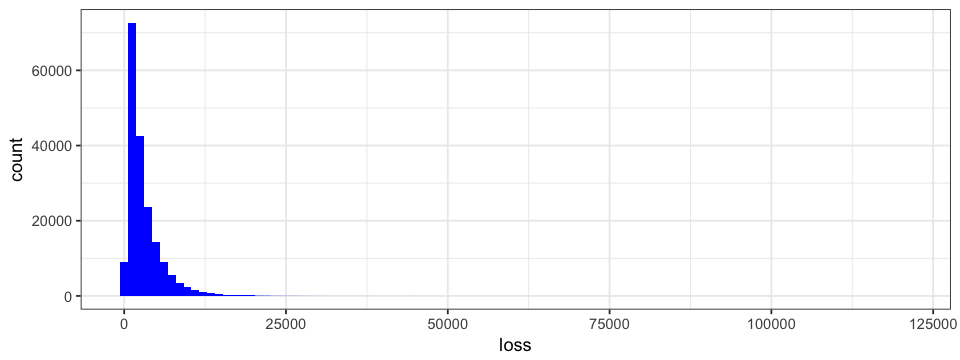

In [141]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(train, aes(x = loss)) + geom_histogram(bins = 100, fill = "blue") + theme_bw()

### Any thoughts?

## Prepare to modeling

In [ ]:
y_train = train$loss
train[, c("id", "loss") := NULL]

XGBoost works only with numerical calues... any other should be converated to numerical.

### Categorical into numerical

In [37]:
df = train

for (f in features) {
  if (class(df[[f]])=="character") {
    levels <- sort(unique(df[[f]]))
    df[[f]] <- as.integer(factor(df[[f]], levels=levels))
  }
}

## one hot encoding
can be slow...

In [163]:
oh.train = train

for (f in names(train)[names(train) %like% "^cat"]) {
    dmy <- dummyVars(sprintf(" ~ %s", f), data = train)
    newDum <- data.table(predict(dmy, newdata = train))
    
    oh.train = cbind(oh.train, newDum)
}

## train model

In [68]:
set.seed(2017)

dtrain = xgb.DMatrix(as.matrix(df), label=y_train)

xgb_params = list(
    objective='reg:linear', 
    eval_metric = "mae",
    max_depth = 10
)
model = xgb.train(xgb_params, dtrain, nrounds=30, maximize = F)

## predict model

In [69]:
y_pred = predict(model,dtrain)
mae(y_train, y_pred)

[1] 1000.238

## Any issues?

### Tips
- validation

###  k-fold Cross Validation

In [70]:
res = xgb.cv(
    xgb_params, 
    dtrain, 
    prediction =T,
    nrounds=30, 
    nfold=3,
    verbose=1
)

[1]	train-mae:2153.059245+7.470566	test-mae:2158.650635+19.567839 
[2]	train-mae:1637.004964+6.762716	test-mae:1656.250366+17.548189 
[3]	train-mae:1375.164388+7.881921	test-mae:1412.830566+12.958487 
[4]	train-mae:1249.742432+9.041052	test-mae:1304.854492+10.572649 
[5]	train-mae:1185.916870+9.486604	test-mae:1258.568441+8.812283 
[6]	train-mae:1153.010539+9.291867	test-mae:1241.483805+9.637509 
[7]	train-mae:1133.609660+10.127964	test-mae:1234.950033+8.126698 
[8]	train-mae:1117.499715+10.801563	test-mae:1231.734416+6.997436 
[9]	train-mae:1104.506266+10.648119	test-mae:1230.018311+5.752851 
[10]	train-mae:1094.974528+8.493094	test-mae:1229.443156+6.860485 
[11]	train-mae:1085.386352+9.017015	test-mae:1228.035238+6.789870 
[12]	train-mae:1075.641561+9.897941	test-mae:1227.096436+5.976828 
[13]	train-mae:1067.792277+9.417031	test-mae:1225.805990+5.954158 
[14]	train-mae:1057.835246+8.166014	test-mae:1224.805827+6.278466 
[15]	train-mae:1048.299113+8.388607	test-mae:1223.641276+6.30605

## Any issues?

### Tips
- compare train-mae vs test-mae

Let's decrise `max_depth` from 10 to 5

In [81]:
xgb_params = list(
    objective='reg:linear', 
    eval_metric = "mae",
    max_depth = 5
)

res = xgb.cv(
    xgb_params, 
    dtrain, 
    prediction =T,
    nrounds=30, 
    nfold=3,
    verbose=1
)

[1]	train-mae:2158.451172+3.542729	test-mae:2159.255208+8.664711 
[2]	train-mae:1680.657104+1.212815	test-mae:1683.335164+9.322993 
[3]	train-mae:1454.712931+0.562066	test-mae:1458.127319+7.882483 
[4]	train-mae:1359.080241+2.006828	test-mae:1364.622721+8.459649 
[5]	train-mae:1319.730754+0.707579	test-mae:1326.753255+5.642203 
[6]	train-mae:1298.236125+3.333178	test-mae:1307.390340+7.172061 
[7]	train-mae:1287.257528+0.949397	test-mae:1297.876058+4.524106 
[8]	train-mae:1280.598796+2.008944	test-mae:1292.802531+1.723555 
[9]	train-mae:1273.578532+1.936364	test-mae:1287.634359+1.978019 
[10]	train-mae:1266.206380+4.255002	test-mae:1281.524170+0.973047 
[11]	train-mae:1258.862468+3.048014	test-mae:1275.310873+1.915191 
[12]	train-mae:1252.787761+3.281192	test-mae:1270.040487+1.354098 
[13]	train-mae:1246.876221+3.881155	test-mae:1265.515625+2.816074 
[14]	train-mae:1242.045776+4.051238	test-mae:1261.715373+3.079416 
[15]	train-mae:1236.667765+3.425280	test-mae:1257.236410+2.521531 
[16]

### Play around with:
- eta
- subsample (0..1)
- colsample_bytree (0..1)

## Play around with target variable

In [164]:
#tips: check ggplot + scale_y_log10()

## Links
* [xgboost docs](http://xgboost.readthedocs.io/en/latest/R-package/xgboostPresentation.html)
* [tutorial #1](https://www.analyticsvidhya.com/blog/2016/01/xgboost-algorithm-easy-steps/), [tutorial #2](https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/)
* [xbfi](https://github.com/Far0n/xgbfi) worth to check
 